# Import packages

In [1]:
import ast
import math
import numpy as np
import altair as alt
import pandas as pd
import shapely as shp
import geopandas as gpd
from datetime import timedelta, time
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.widgets import Button, Slider, CheckButtons
import matplotlib.patches as mpatches

import itertools
from dijkstar import Graph, find_path

from helper_functions import open_delays, create_timesteps, open_stations, plot_map_view

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

# Notebook settings

In [2]:
DELAYS_FILEPATH = r'Intermediates\\delays_assigned.csv'
LINKS_FILEPATH = r'Intermediates\\GTFS_20190914\\gtfs_links_corrected.geojson'
STATIONS_FILEPATH = r'Intermediates\\GTFS_20190914\\gtfs_stations_corrected.geojson'
RESULTS_FILEPATH = r'First model results\\D05 to D06 30.csv'
timestep_size = 30  # minutes
# RESULTS_ABOVE_ZERO_FILEPATH = r'First model results\\D05 to D06 above zero.csv'


distribution = stats.exponnorm
# distribution_above_zero = stats.halflogistic

column_titles= ['VARIABLE', 'OPTION', 'EXAMPLE VALUE']
variable_names = ['delayed station-direction', 'delay magnitude range', 'delay occurrence time step', 'station-direction to analyse', 'timestep at to analyse']

# Load data

In [3]:
gtfs_stations = open_stations(STATIONS_FILEPATH)
gtfs_stations.head(3)

,stop_id,stop_name,connections,geometry
0,E02,SHAW METRO STATION,"[[E03, E01], [E01, E03]]",POINT (1306094.353 454461.868)
1,D11,CHEVERLY METRO STATION,"[[D10, D12], [D12, D10]]",POINT (1336488.46 455202.936)
2,G02,CAPITOL HEIGHTS METRO STATION,"[[G01, G03], [G03, G01]]",POINT (1337007.377 445376.966)


In [4]:
# delays = open_delays(DELAYS_FILEPATH)
# delays.head(3)

In [5]:
results = pd.read_csv(RESULTS_FILEPATH, converters={"connection": eval, "other_connection": eval, 'dist_params': eval})
results.head(3)

,connection,delay_range,timestep,other_connection,future_timestep,dist_params
0,"(D05, D06)",0.0,5.5,"(A01/C01, A02)",5.5,"[1.9363084332005704, -44.1373622808718, 35.677..."
1,"(D05, D06)",0.0,5.5,"(A01/C01, A02)",6.0,"[1.2227026596129429, -27.431958741291933, 41.9..."
2,"(D05, D06)",0.0,5.5,"(A01/C01, A02)",6.5,"[0.5142080401311502, -32.00646405117415, 61.34..."


In [6]:
links = gpd.read_file(LINKS_FILEPATH)
print(f"Amount of network connections: {len(links):_}")
links.head(3)

Amount of network connections: 189


,link_id,from_stop,to_stop,travel_time,geometry
0,A15_to_A14,A15,A14,240,"LINESTRING (-77.16476 39.11999, -77.14669 39.0..."
1,A14_to_A13,A14,A13,180,"LINESTRING (-77.14669 39.08545, -77.12079 39.0..."
2,A13_to_A12,A13,A12,180,"LINESTRING (-77.12079 39.06239, -77.11278 39.0..."


# Examine per dimension

We have five dimensions variables, we can choose which selection for each we want to study:
- Station direction pair which is the delay originator                                                      (Spatial - 2D)      (originator connection)
- Amount of delay to occur at the originator station-direction                                              (Magnitude - 1D)    (originator delay range)
- Timestep at which the requested amount of delay occurs at the originator station-direction                (Temporal - 1D)     (originator timestep)

- Station direction pair which is affected by the originator delay                                          (Spatial - 2D)      (affected connection)
- Timestep for which we want to analyse the behaviour at the affect station-direction due to the originator (Temporal - 1D)     (affected timestep)

## 1. Effect of one delay with one range at one connection at one time on all other connections at one time
Originator connection = choose 1

Originator delay range = choose 1

Originator timestep = choose 1

Affected connection = All

Affected timestep = choose 1

In [10]:
originator_connection = ('D05', 'D06')
originator_delay_range = 4
originator_timestep = 9.0
# affected_connection = all
affected_timestep = 10.0

In [11]:
# Get station values
plot_specific_results = results[(results['connection'] == originator_connection) & \
                                (results['delay_range'] == originator_delay_range) & \
                                (results['timestep'] == originator_timestep) & \
                                (results['future_timestep'] == affected_timestep)]

station_values_dict = {}
for _, station in gtfs_stations.iterrows():
    station_id = station['stop_id']
    station_values_dict[station_id] = {}

    for direction in [connection[1] for connection in station['connections'] if connection[1] != 'None']:
        func = plot_specific_results[plot_specific_results['other_connection'] == (station_id, direction)]
        if len(func) == 0:
            station_values_dict[station_id][direction] = None
        else:
            fun_params = func.iloc[0]['dist_params']
            station_values_dict[station_id][direction] = distribution.mean(*fun_params)


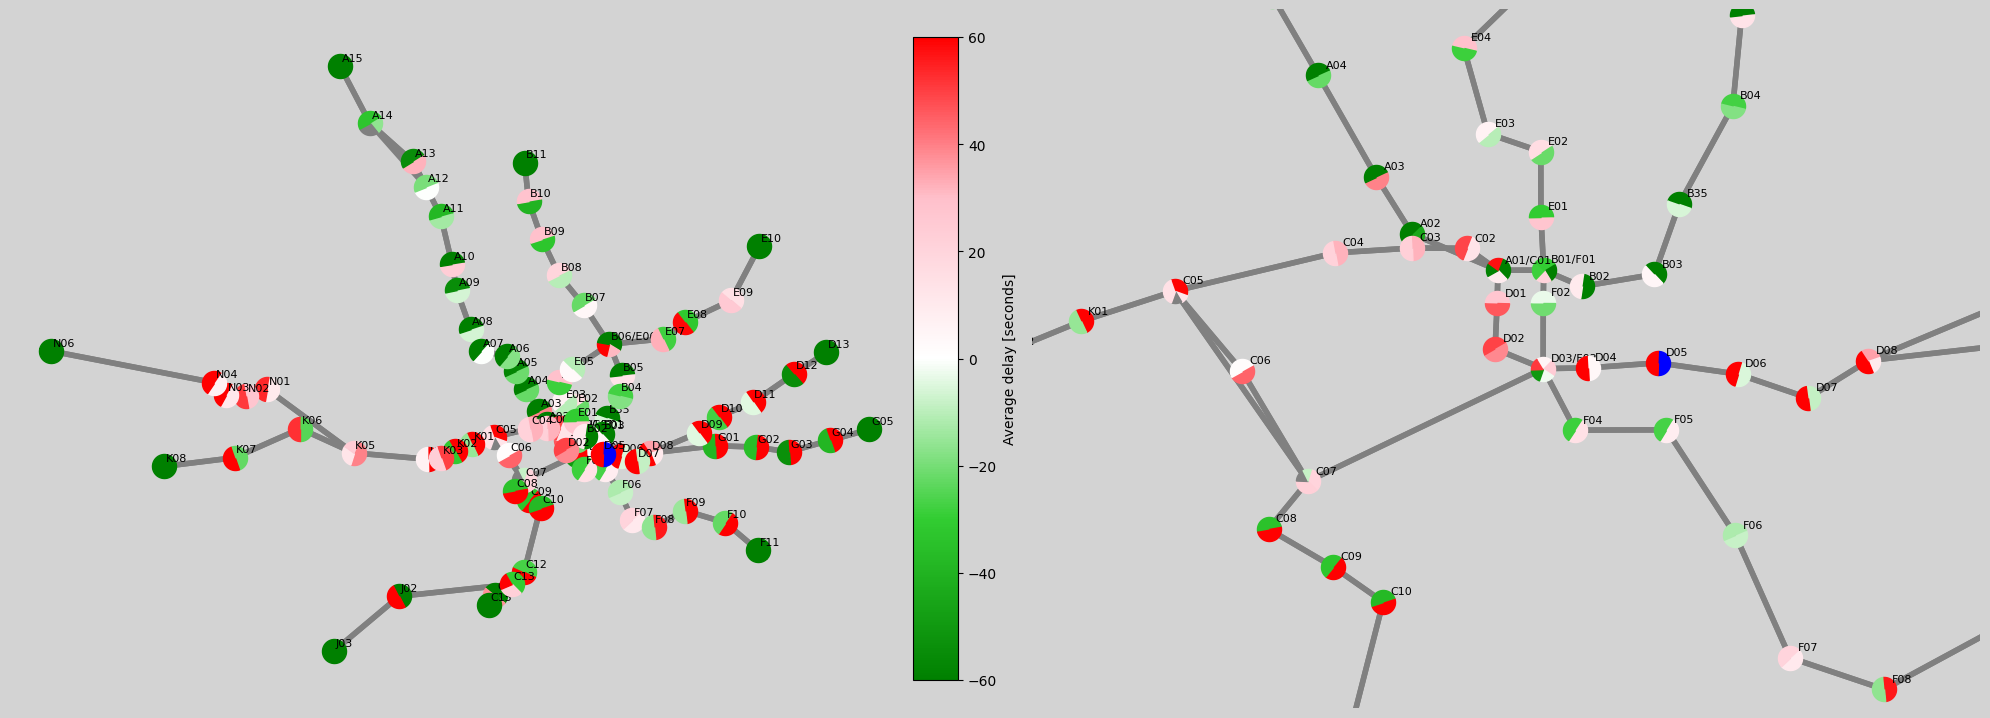

In [12]:
# %matplotlib qt
fig = plot_map_view(gtfs_stations, links, station_values=station_values_dict, originator_connection=originator_connection, cmap_bounds=[-60, 0, 60])

fig.savefig(r'C:\Users\lange\OneDrive\Documenten\Jaar_6-Msc_CE_TTE\Thesis\Codebase\Codebase figures\first_model_results_1.png', dpi=200)

## 2. Delay behaviour at one connection at one timestep given one delay range at all other connections at one other previous timestep
Originator connection = All

Originator delay range = choose 1

Originator timestep = choose 1

Affected connection = choose 1

Affected timestep = choose 1

In [ ]:
originator_connection = ('D05', 'D06')
originator_delay_range = 0
originator_timestep = 9.0
# affected_connection = all
affected_timestep = 10.0

## 3. Delay behaviour at one connection given one delay range at one connection for all timesteps for all future timesteps
Originator connection = choose 1

Originator delay range = choose 1

Originator timestep = All

Affected connection = choose 1

Affected timestep = ALL

In [ ]:
originator_connection = ('D05', 'D06')
originator_delay_range = 4
# originator_timestep = All
affected_connection = ('A10', 'A11')
# affected_timestep = All

In [ ]:
plot_specific_results = results[(results['connection'] == originator_connection) & \
                                (results['delay_range'] == originator_delay_range) & \
                                (results['other_connection'] == affected_connection)]

plot_dict = {}
for timestep in plot_specific_results['timestep'].unique():
    timestep_i_funcs = plot_specific_results[plot_specific_results['timestep'] == timestep]
    timestep_i_funcs = timestep_i_funcs.sort_values(by=['future_timestep'])
    
    plot_dict[timestep] = {'xs': [], 'ys': []}
    for _, func_i in timestep_i_funcs.iterrows():
        func_params = func_i['dist_params']
        value = distribution.mean(*func_params)

        plot_dict[timestep]['xs'].append(func_i['future_timestep'])
        plot_dict[timestep]['ys'].append(value)


In [ ]:
plot_specific_results

,connection,delay_range,timestep,other_connection,future_timestep,dist_params
455650,"(D05, D06)",4.0,6.0,"(A10, A11)",6.0,"[1.1832145737347304, -70.593571089844, 40.6934..."
455651,"(D05, D06)",4.0,6.0,"(A10, A11)",6.5,"[1.4091447827967745, -99.77687071002468, 52.66..."
455652,"(D05, D06)",4.0,6.0,"(A10, A11)",7.0,"[0.1429481113297952, -98.32681868116423, 60.62..."
455653,"(D05, D06)",4.0,6.0,"(A10, A11)",7.5,"[1.1766999592366107, -104.99794540239023, 41.0..."
455654,"(D05, D06)",4.0,6.0,"(A10, A11)",8.0,"[1.862813944767151, -113.35488025481924, 33.13..."
...,...,...,...,...,...,...
542011,"(D05, D06)",4.0,19.0,"(A10, A11)",22.0,"[2.0171785583655217, -181.82642620074387, 73.0..."
543673,"(D05, D06)",4.0,20.5,"(A10, A11)",20.5,"[2.035058177017033, -174.58149909116298, 72.25..."
543674,"(D05, D06)",4.0,20.5,"(A10, A11)",21.0,"[1.7472523062774494, -174.3436172516842, 79.74..."
543675,"(D05, D06)",4.0,20.5,"(A10, A11)",21.5,"[5.342502059657507, -187.51604454129395, 31.10..."


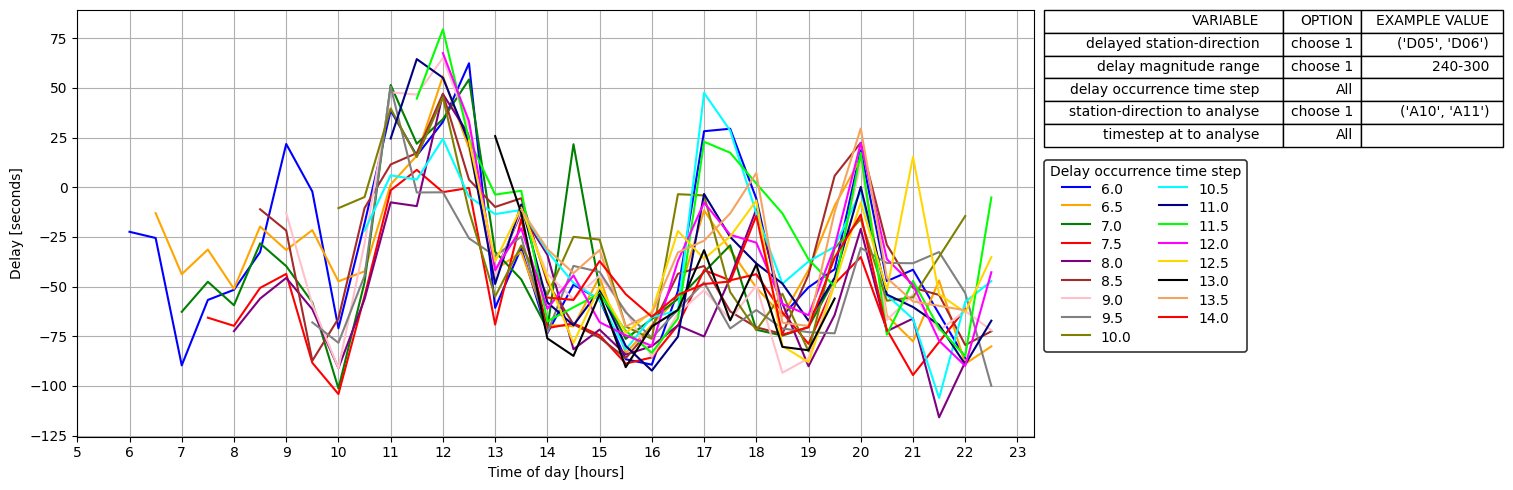

In [ ]:
fig = plt.figure(figsize=(17, 5))
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 
          'cyan', 'navy', 'lime', 'magenta', 'gold', 'black', 'sandybrown', 'red']

for (timestep, timestep_data), color in zip(plot_dict.items(), colors):
    plt.plot(timestep_data['xs'], timestep_data['ys'], color=color, label=timestep)

# plt.title(f"Given a delay between {int(originator_delay_range*60)} and {int((originator_delay_range+1)*60)} seconds at \
# {originator_connection[0]}->{originator_connection[1]} at a certain hour of the day, \n \
# what is the mean delay at {affected_connection[0]}->{affected_connection[1]} for the remaining hours of the day?")
plt.xlabel('Time of day [hours]')
plt.ylabel('Delay [seconds]')
plt.grid()

legend = plt.legend(bbox_to_anchor=(1.003, 0.665),  ncol=2,handleheight=1.6, labelspacing=0.05, title="Delay occurrence time step")
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(1.2)

options = ['choose 1', 'choose 1', 'All', 'choose 1', 'All']
values = originator_connection, f"{int(originator_delay_range*60)}-{int((originator_delay_range+1)*60)}", None, affected_connection, None
cell_texts = [column_titles] + [[name, option, value] for name, option, value in zip(variable_names, options, values)]

the_table = plt.table(cellText=cell_texts, loc='center right', bbox=[1.01, 0.68, 0.48, 0.32])
the_table.auto_set_font_size(False)
the_table.auto_set_column_width(col=list(range(3)))

# plt.ylim(-50, 150)
plt.xticks(np.arange(5, 24, 1))
plt.tight_layout()

fig.savefig(r'C:\Users\lange\OneDrive\Documenten\Jaar_6-Msc_CE_TTE\Thesis\Codebase\Codebase figures\first_model_results_2.png', dpi=200)

## 4. Delay behaviour at one connection for all timesteps given a delay at another connection at a specific time for all possible delay range
Originator connection = choose 1

Originator delay range = All

Originator timestep = choose 1

Affected connection = choose 1

Affected timestep = All at and after originator timestep

In [ ]:
originator_connection = ('D05', 'D06')
# originator_delay_range = 4
originator_timestep = 8
affected_connection = ('A10', 'A11')
# affected_timestep = All

In [ ]:
plot_specific_results = results[(results['connection'] == originator_connection) & \
                                (results['timestep'] == originator_timestep) & \
                                (results['other_connection'] == affected_connection)]

plot_dict = {}
for delay_range in plot_specific_results['delay_range'].unique():
    delay_range_i_funcs = plot_specific_results[plot_specific_results['delay_range'] == delay_range]
    delay_range_i_funcs = delay_range_i_funcs.sort_values(by=['future_timestep'])
    
    plot_dict[delay_range] = {'xs': [], 'ys': []}
    for _, func_i in delay_range_i_funcs.iterrows():
        func_params = func_i['dist_params']
        value = distribution.mean(*func_params)

        plot_dict[delay_range]['xs'].append(func_i['future_timestep'])
        plot_dict[delay_range]['ys'].append(value)


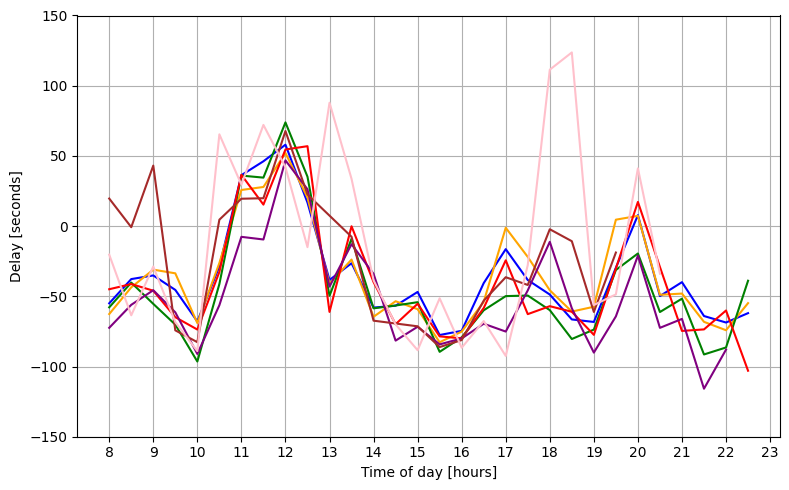

In [ ]:
fig = plt.figure(figsize=(8, 5))
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 
          'cyan', 'navy', 'lime', 'magenta', 'gold', 'black', 'sandybrown', 'red', 'blue']

for (delay_range, delay_range_data), color in zip(plot_dict.items(), colors):
    if delay_range == 7:
        plt.plot(delay_range_data['xs'], delay_range_data['ys'], color=color, label=f"{int(delay_range*60)}+")
    elif delay_range < 7:
        plt.plot(delay_range_data['xs'], delay_range_data['ys'], color=color, label=f"{int(delay_range*60)}-{int((delay_range+1)*60)}")

# plt.title(f"For a delay at {originator_timestep}:00 at {originator_connection[0]}->{originator_connection[1]},\
# what is the average delay at \n {affected_connection[0]}->{affected_connection[1]} after {originator_timestep}:00 for all possible delay ranges?")
plt.xlabel('Time of day [hours]')
plt.ylabel('Delay [seconds]')
plt.grid()

# legend = plt.legend(bbox_to_anchor=(1.003, 0.665),  ncol=2,handleheight=1.6, labelspacing=0.05, title="Delay magnitude range")
# legend.get_frame().set_edgecolor('black')
# legend.get_frame().set_linewidth(1.2)

options = ['choose 1', 'All', 'choose 1', 'choose 1', 'All']
values = originator_connection, None, f"{originator_timestep}:00", affected_connection, None
cell_texts = [column_titles] + [[name, option, value] for name, option, value in zip(variable_names, options, values)]

# the_table = plt.table(cellText=cell_texts, loc='center right', bbox=[1.01, 0.68, 0.48, 0.32])
# the_table.auto_set_font_size(False)
# the_table.auto_set_column_width(col=list(range(3)))

plt.ylim(-150, 150)
plt.xticks(np.arange(originator_timestep, 24, 1))
plt.tight_layout()

# plt.title("60 Minute Timestep Size")
fig.savefig(f"C:\\Users\\lange\\OneDrive\\Documenten\\Jaar_6-Msc_CE_TTE\\Thesis\\Codebase\\Codebase figures\\first_model_results_3_{timestep_size}.png", dpi=200)

## 5. Delay behaviour at one connection for all timesteps for a specific delay at all other stations
Originator connection = All

Originator delay range = choose 1

Originator timestep = choose 1

Affected connection = choose 1

Affected timestep = All at and after originator timestep

In [ ]:
# originator_connection = ('D05', 'D06')
originator_delay_range = 1
originator_timestep = 9
affected_connection = ('F06', 'F07')
# affected_timestep = All

## 6. Delay behaviour at all connections for all timesteps at and after a specific delay at one connection
Originator connection = All

Originator delay range = choose 1

Originator timestep = choose 1

Affected connection = choose 1

Affected timestep = All at and after originator timestep

In [ ]:
originator_connection = ('D05', 'D06')
originator_delay_range = 6.0
originator_timestep = 9.0
# affected_connection = ('F06', 'F07')
# affected_timestep = All at and after originator

In [ ]:
plot_specific_results = results[(results['connection'] == originator_connection) & \
                                (results['delay_range'] == originator_delay_range) & \
                                (results['timestep'] == originator_timestep)]

plot_dict = {}
for affected_connection in plot_specific_results['other_connection'].unique():
    connection_i_funcs = plot_specific_results[plot_specific_results['other_connection'] == affected_connection]
    connection_i_funcs = connection_i_funcs.sort_values(by=['future_timestep']) 

    plot_dict[affected_connection] = {'xs': [], 'ys': []}
    for _, func_i in connection_i_funcs.iterrows():
        func_params = func_i['dist_params']
        value = distribution.mean(*func_params)

        plot_dict[affected_connection]['xs'].append(func_i['future_timestep'])
        plot_dict[affected_connection]['ys'].append(value)


In [ ]:
plot_specific_results

,connection,delay_range,timestep,other_connection,future_timestep,dist_params
193681,"(D05, D06)",6.0,9.0,"(A01/C01, A02)",9.0,"[0.648705625339222, -78.29713449978274, 93.124..."
193682,"(D05, D06)",6.0,9.0,"(A01/C01, A02)",10.0,"[1.3632376333770488, -107.59188816854797, 63.4..."
193683,"(D05, D06)",6.0,9.0,"(A01/C01, A02)",11.0,"[1.3921316074445134, -88.08817239908589, 71.75..."
193684,"(D05, D06)",6.0,9.0,"(A01/C01, A02)",12.0,"[0.0009138212768408499, 25.76158501910416, 101..."
193685,"(D05, D06)",6.0,9.0,"(A01/C01, A02)",13.0,"[0.9261957731641246, -68.6888521245692, 95.699..."
...,...,...,...,...,...,...
196266,"(D05, D06)",6.0,9.0,"(N06, N04)",17.0,"[0.0006444721157235055, -262.3073446695563, 19..."
196267,"(D05, D06)",6.0,9.0,"(N06, N04)",18.0,"[0.0006639551452831201, -203.39089378426542, 2..."
196268,"(D05, D06)",6.0,9.0,"(N06, N04)",19.0,"[0.0007597552342505867, -242.57906917953738, 1..."
196269,"(D05, D06)",6.0,9.0,"(N06, N04)",20.0,"[0.0011962609431962826, -138.4490682045476, 15..."


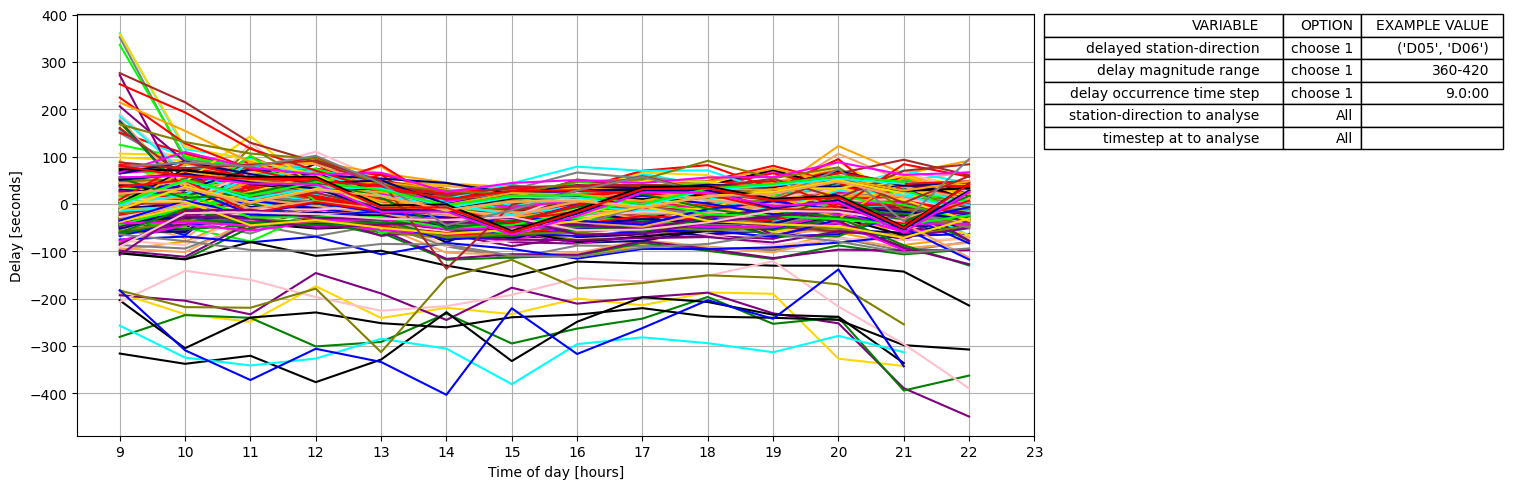

In [ ]:
fig = plt.figure(figsize=(17, 5))
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 
          'cyan', 'navy', 'lime', 'magenta', 'gold', 'black', 'sandybrown', 'red']

for i, (other_connection, other_connection_data) in enumerate(plot_dict.items()):
    color = colors[i % len(colors)]
    plt.plot(other_connection_data['xs'], other_connection_data['ys'], color=color)

# plt.title(f"For a delay between {int(originator_delay_range*60)} and {int((originator_delay_range+1)*60)} seconds at \
# {originator_connection[0]}->{originator_connection[1]} at {originator_timestep}:00, \n\
# what is the delay behaviour for all other connection after {originator_timestep}:00?")
plt.xlabel('Time of day [hours]')
plt.ylabel('Delay [seconds]')
plt.grid()
plt.xticks(np.arange(9, 24, 1))

# legend = plt.legend(bbox_to_anchor=(1.003, 0.665),  ncol=2,handleheight=1.6, labelspacing=0.05, title='Station-direction')
# legend.get_frame().set_edgecolor('black')
# legend.get_frame().set_linewidth(1.2)

options = ['choose 1', 'choose 1', 'choose 1', 'All', 'All']
values = originator_connection, f"{int(originator_delay_range*60)}-{int((originator_delay_range+1)*60)}", f"{originator_timestep}:00", None, None
cell_texts = [column_titles] + [[name, option, value] for name, option, value in zip(variable_names, options, values)]

the_table = plt.table(cellText=cell_texts, loc='center right', bbox=[1.01, 0.68, 0.48, 0.32])
the_table.auto_set_font_size(False)
the_table.auto_set_column_width(col=list(range(3)))

plt.tight_layout()

fig.savefig(r'C:\Users\lange\OneDrive\Documenten\Jaar_6-Msc_CE_TTE\Thesis\Codebase\Codebase figures\first_model_results_4_1.png', dpi=200)

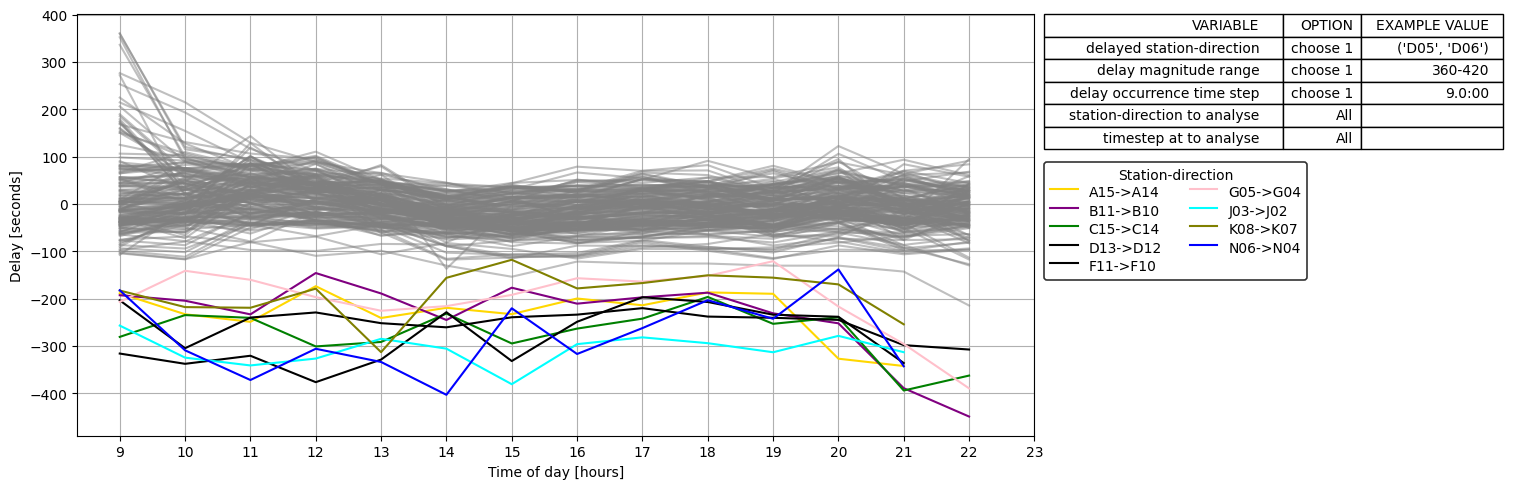

In [ ]:
fig = plt.figure(figsize=(17, 5))
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 
          'cyan', 'navy', 'lime', 'magenta', 'gold', 'black', 'sandybrown', 'red']

for i, (other_connection, other_connection_data) in enumerate(plot_dict.items()):
    color = colors[i % len(colors)]
    if other_connection_data['ys'][0] < -150:
        plt.plot(other_connection_data['xs'], other_connection_data['ys'], color=color, label=f"{other_connection[0]}->{other_connection[1]}")
    else:
        plt.plot(other_connection_data['xs'], other_connection_data['ys'], color='gray', alpha=0.5)

# plt.title(f"For a delay between {int(originator_delay_range*60)} and {int((originator_delay_range+1)*60)} seconds at \
# {originator_connection[0]}->{originator_connection[1]} at {originator_timestep}:00, \n\
# what is the delay behaviour for all other connection after {originator_timestep}:00?")
plt.xlabel('Time of day [hours]')
plt.ylabel('Delay [seconds]')
plt.grid()
plt.xticks(np.arange(9, 24, 1))

legend = plt.legend(bbox_to_anchor=(1.003, 0.665),  ncol=2,handleheight=1.6, labelspacing=0.05, title='Station-direction')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(1.2)

options = ['choose 1', 'choose 1', 'choose 1', 'All', 'All']
values = originator_connection, f"{int(originator_delay_range*60)}-{int((originator_delay_range+1)*60)}", f"{originator_timestep}:00", None, None
cell_texts = [column_titles] + [[name, option, value] for name, option, value in zip(variable_names, options, values)]

the_table = plt.table(cellText=cell_texts, loc='center right', bbox=[1.01, 0.68, 0.48, 0.32])
the_table.auto_set_font_size(False)
the_table.auto_set_column_width(col=list(range(3)))

plt.tight_layout()
fig.savefig(r'C:\Users\lange\OneDrive\Documenten\Jaar_6-Msc_CE_TTE\Thesis\Codebase\Codebase figures\first_model_results_4_2.png', dpi=200)

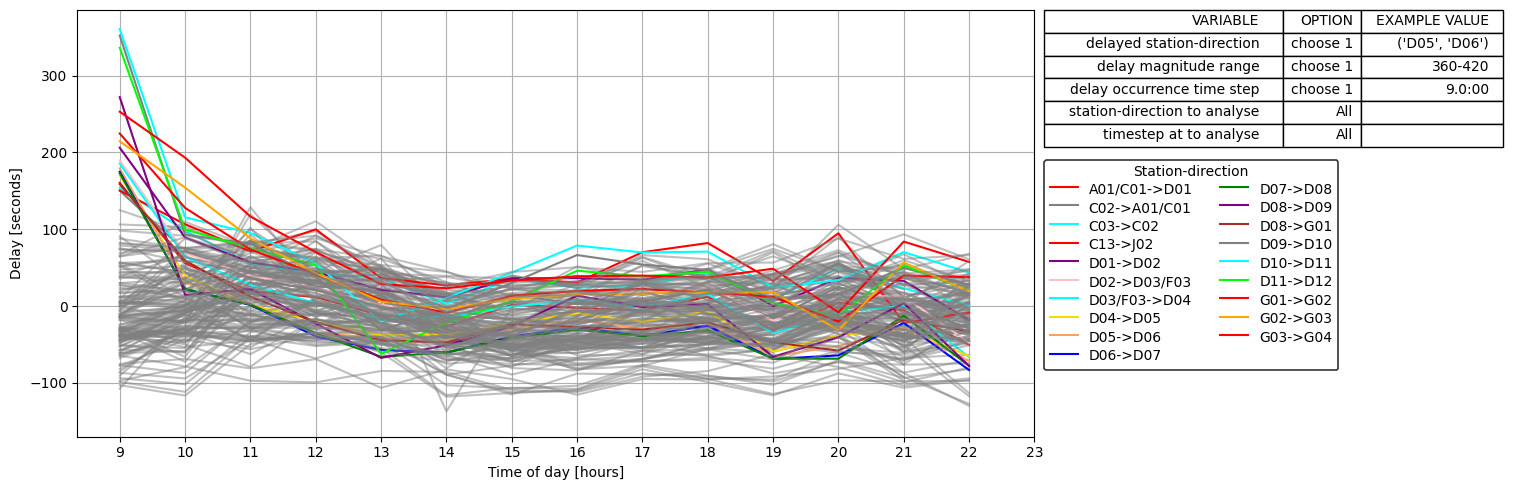

In [ ]:
fig = plt.figure(figsize=(17, 5))
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 
          'cyan', 'navy', 'lime', 'magenta', 'gold', 'black', 'sandybrown', 'red']

for i, (other_connection, other_connection_data) in enumerate(plot_dict.items()):
    if other_connection in [('A15', 'A14'), ('B11', 'B10'), ('C15', 'C14'), ('D13', 'D12'), ('E10', 'E09'), ('F11', 'F10'), ('G05', 'G04'), ('J03', 'J02'), ('K08', 'K07'), ('N06', 'N04')] or \
        (other_connection[1], other_connection[0]) in [('A15', 'A14'), ('B11', 'B10'), ('C15', 'C14'), ('D13', 'D12'), ('E10', 'E09'), ('F11', 'F10'), ('G05', 'G04'), ('J03', 'J02'), ('K08', 'K07'), ('N06', 'N04')]:
        continue

    color = colors[i % len(colors)]
    # if other_connection_data['ys'][0] < -150:
    #     continue
    #     plt.plot(other_connection_data['xs'], other_connection_data['ys'], color=color, label=f"{other_connection[0]}->{other_connection[1]}")
    if other_connection_data['ys'][0] > 130:
        plt.plot(other_connection_data['xs'], other_connection_data['ys'], color=color, label=f"{other_connection[0]}->{other_connection[1]}")
    else:
        plt.plot(other_connection_data['xs'], other_connection_data['ys'], color='gray', alpha=0.5)

# plt.title(f"For a delay between {int(originator_delay_range*60)} and {int((originator_delay_range+1)*60)} seconds at \
# {originator_connection[0]}->{originator_connection[1]} at {originator_timestep}:00, \n\
# what is the delay behaviour for all other connection after {originator_timestep}:00?")
plt.xlabel('Time of day [hours]')
plt.ylabel('Delay [seconds]')
plt.grid()
plt.xticks(np.arange(9, 24, 1))

legend = plt.legend(bbox_to_anchor=(1.003, 0.665),  ncol=2,handleheight=1.6, labelspacing=0.05, title='Station-direction')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(1.2)

options = ['choose 1', 'choose 1', 'choose 1', 'All', 'All']
values = originator_connection, f"{int(originator_delay_range*60)}-{int((originator_delay_range+1)*60)}", f"{originator_timestep}:00", None, None
cell_texts = [column_titles] + [[name, option, value] for name, option, value in zip(variable_names, options, values)]

the_table = plt.table(cellText=cell_texts, loc='center right', bbox=[1.01, 0.68, 0.48, 0.32])
the_table.auto_set_font_size(False)
the_table.auto_set_column_width(col=list(range(3)))

plt.ylim(bottom=-170)
plt.tight_layout()

fig.savefig(r'C:\Users\lange\OneDrive\Documenten\Jaar_6-Msc_CE_TTE\Thesis\Codebase\Codebase figures\first_model_results_4_3.png', dpi=200)